In [1]:
# imports
import h2o 
import numpy as np
import pandas as pd
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [2]:
# display matplotlib graphics in notebook
%matplotlib inline

In [3]:
# start and connect to h2o server
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp4s5aeiwn
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp4s5aeiwn/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp4s5aeiwn/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.11.0.3873
H2O cluster version age:,5 days
H2O cluster name:,H2O_from_python_phall_mknavc
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [4]:
# location of clean data file
path = 'https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv'

In [5]:
# define input variable measurement levels 
# strings automatically parsed as enums (nominal)
# numbers automatically parsed as numeric
col_types = {'bad_loan': 'enum'}

In [6]:
frame = h2o.import_file(path=path, col_types=col_types) # import from url

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
frame.describe() # summarize data

Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,enum,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,,0.0,
mean,13074.169141456332,,13.715904065566189,5.684352932995338,,71915.67051974905,,,15.881530121290167,0.22735700606252723,54.07917280242262,24.579733834274574,,14.854273655448333,
maxs,35000.0,,26.060000000000002,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,,65.0,
sigma,7993.556188734672,,4.391939870545809,3.610663731100238,,59070.91565491818,,,7.5876682241925355,0.6941679229284191,25.285366766770498,11.685190365910666,,6.947732922546689,
zeros,0,,0,14248,,0,,,270,139459,1562,0,,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.650000000000002,0.0,83.7,9.0,0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified


In [8]:
# split into 40% training, 30% validation, and 30% test
train, valid, test = frame.split_frame([0.4, 0.3])

In [9]:
# assign target and inputs
y = 'bad_loan'
X = [name for name in frame.columns if name != y]
print(y)
print(X)

bad_loan
['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'revol_util', 'total_acc', 'longest_credit_length', 'verification_status']


In [10]:
# set target to factor - for binary classification
# just to be safe ... 
train[y] = train[y].asfactor()
valid[y] = valid[y].asfactor()
test[y] = test[y].asfactor()

In [11]:
# random forest
# random forest is often best guess model with little tuning

# initialize rf model
rf_model = H2ORandomForestEstimator(
    ntrees=500,                      # Up to 500 decision trees in the forest 
    max_depth=30,                    # trees can grow to depth of 30
    stopping_rounds=5,               # stop after validation error does not decrease for 5 iterations/new trees
    score_each_iteration=True,       # score validation error on every iteration/new tree
    model_id='rf_model')             # for easy lookup in flow

# train rf model
rf_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid)

# print model information
rf_model

# view detailed results at http://ip:port/flow/index.html

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_model


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.14112276920019975
RMSE: 0.37566310598753205
LogLoss: 0.48501594009595156
Mean Per-Class Error: 0.36451570234944497
AUC: 0.6838283414535311
Gini: 0.3676566829070622
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2174401945817948: 


,0,1,Error,Rate
0,36636.0,17006.0,0.317,(17006.0/53642.0)
1,4995.0,7070.0,0.414,(4995.0/12065.0)
Total,41631.0,24076.0,0.3348,(22001.0/65707.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2174402,0.3912454,234.0
max f2,0.1024899,0.5539611,326.0
max f0point5,0.3125069,0.3487051,168.0
max accuracy,0.6409111,0.8166101,19.0
max precision,0.7558266,0.7272727,3.0
max recall,0.0000064,1.0,399.0
max specificity,0.8372093,0.9999814,0.0
max absolute_mcc,0.2186485,0.2162146,233.0
max min_per_class_accuracy,0.2000068,0.6348114,247.0
max mean_per_class_accuracy,0.1874921,0.6354843,257.0


Gains/Lift Table: Avg response rate: 18.36 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102120,0.8264463,5.4460837,5.4460837,1.0,1.0,0.0556154,0.0556154,444.6083713,444.6083713
,2,0.0213067,0.8016529,5.4460837,5.4460837,1.0,1.0,0.0604227,0.1160381,444.6083713,444.6083713
,3,0.0314122,0.7851240,5.4460837,5.4460837,1.0,1.0,0.0550352,0.1710734,444.6083713,444.6083713
,4,0.0440136,0.7685950,5.4460837,5.4460837,1.0,1.0,0.0686283,0.2397016,444.6083713,444.6083713
,5,0.0508469,0.7603306,5.4460837,5.4460837,1.0,1.0,0.0372151,0.2769167,444.6083713,444.6083713
,6,0.1038702,0.7107438,5.4460837,5.4460837,1.0,1.0,0.2887692,0.5656859,444.6083713,444.6083713
,7,0.1499992,0.6607247,5.4460837,5.4460837,1.0,1.0,0.2512225,0.8169084,444.6083713,444.6083713
,8,0.2000091,0.1941821,3.6611074,4.9997717,0.6722459,0.9180490,0.1830916,1.0,266.1107402,399.9771724
,9,0.3004246,0.1198347,0.0,3.3286221,0.0,0.6111955,0.0,1.0,-100.0,232.8622087
,10,0.4154961,0.0909091,0.0,2.4067617,0.0,0.4419252,0.0,1.0,-100.0,140.6761657




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.14027905622596717
RMSE: 0.3745384576061144
LogLoss: 0.4468121244162331
Mean Per-Class Error: 0.36570520320152466
AUC: 0.6847154749461258
Gini: 0.36943094989225167
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21075676792435624: 


,0,1,Error,Rate
0,26852.0,13170.0,0.3291,(13170.0/40022.0)
1,3631.0,5360.0,0.4038,(3631.0/8991.0)
Total,30483.0,18530.0,0.3428,(16801.0/49013.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2107568,0.3895207,241.0
max f2,0.1186305,0.5554027,318.0
max f0point5,0.3108780,0.3492397,164.0
max accuracy,0.5949698,0.8171710,30.0
max precision,0.5949698,0.5806452,30.0
max recall,0.0000105,1.0,399.0
max specificity,0.7925620,0.9999750,0.0
max absolute_mcc,0.2107568,0.2131732,241.0
max min_per_class_accuracy,0.1983480,0.6281795,252.0
max mean_per_class_accuracy,0.1872978,0.6342948,261.0


Gains/Lift Table: Avg response rate: 18.34 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0104666,0.5371901,2.7097305,2.7097305,0.4970760,0.4970760,0.0283617,0.0283617,170.9730523,170.9730523
,2,0.0201375,0.4958678,2.5071565,2.6124457,0.4599156,0.4792300,0.0242465,0.0526082,150.7156477,161.2445723
,3,0.0304205,0.4669421,2.4552663,2.5593147,0.4503968,0.4694836,0.0252475,0.0778556,145.5266333,155.9314662
,4,0.0401118,0.4462810,2.1805361,2.4677990,0.4,0.4526958,0.0211322,0.0989879,118.0536092,146.7798985
,5,0.0500071,0.4249615,2.0119379,2.3775939,0.3690722,0.4361485,0.0199088,0.1188967,101.1937940,137.7593923
,6,0.1015037,0.3636364,1.8725483,2.1213658,0.3435024,0.3891457,0.0964298,0.2153264,87.2548328,112.1365766
,7,0.1535307,0.3223140,1.6546421,1.9632069,0.3035294,0.3601329,0.0860861,0.3014125,65.4642093,96.3206913
,8,0.2077000,0.2892562,1.5193943,1.8474581,0.2787194,0.3388998,0.0823045,0.3837171,51.9394263,84.7458133
,9,0.3109991,0.2396694,1.2985021,1.6651210,0.2381987,0.3054517,0.1341341,0.5178512,29.8502136,66.5121046
,10,0.4008120,0.2024793,1.1207321,1.5431358,0.2055884,0.2830746,0.1006562,0.6185074,12.0732146,54.3135811



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-05-15 18:03:32,0.328 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2017-05-15 18:03:33,1.243 sec,1.0,0.5289717,9.6382471,0.5400774,3.9002324,0.8151549,0.5271094,9.5686756,0.5422178,1.3601808,0.8165589
,2017-05-15 18:03:33,1.759 sec,2.0,0.5126750,8.4742532,0.5463569,5.1753987,0.8173624,0.4572148,4.8998308,0.5685571,1.6325224,0.3615979
,2017-05-15 18:03:33,2.141 sec,3.0,0.4971746,7.4905289,0.5535250,5.4008584,0.8166069,0.4310193,3.3370178,0.5838537,1.8995992,0.4247037
,2017-05-15 18:03:34,2.435 sec,4.0,0.4821143,6.5507212,0.5617473,5.4411237,0.8161722,0.4169189,2.5766273,0.5969630,1.8639419,0.4739559
---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2017-05-15 18:08:06,4 min 35.025 sec,117.0,0.3757872,0.4904917,0.6833845,5.4460837,0.3453818,0.3745609,0.4468728,0.6845276,2.7094136,0.3476629
,2017-05-15 18:08:11,4 min 39.631 sec,118.0,0.3757919,0.4891116,0.6833361,5.4460837,0.3453361,0.3745674,0.4468912,0.6845169,2.6868113,0.3490503
,2017-05-15 18:08:16,4 min 44.287 sec,119.0,0.3757721,0.4876682,0.6834172,5.4460837,0.3322477,0.3745908,0.4469251,0.6844455,2.7256701,0.3356048
,2017-05-15 18:08:20,4 min 48.957 sec,120.0,0.3757365,0.4852009,0.6835567,5.4460837,0.3475885,0.3745559,0.4468453,0.6846320,2.7643713,0.3380124



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
addr_state,133626.7187500,1.0,0.1797380
int_rate,89964.1406250,0.6732496,0.1210085
dti,71187.8515625,0.5327367,0.0957530
revol_util,69533.7109375,0.5203578,0.0935281
loan_amnt,61661.7070312,0.4614474,0.0829396
total_acc,59498.0117188,0.4452554,0.0800293
annual_inc,57380.6054688,0.4294097,0.0771812
longest_credit_length,56439.1914062,0.4223646,0.0759150
emp_length,47715.6718750,0.3570818,0.0641812
purpose,42303.2460938,0.3165778,0.0569010


In [12]:
# measure rf AUC
print(rf_model.auc(train=True))
print(rf_model.auc(valid=True))
print(rf_model.model_performance(test_data=test).auc())

0.6838283414535311
0.6847154749461258
0.6881952471256322


In [13]:
# GBM is often more accurate the RF, but requires more tuning
# GBM with random hyperparameter search
# train many different GBM models with random hyperparameters
# and select best model based on validation error

# define random grid search parameters
hyper_parameters = {'ntrees':list(range(50, 500, 50)),
                    'max_depth':list(range(2, 20, 2)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':20,
                   'max_runtime_secs':600}

# initialize grid search
gsearch = H2OGridSearch(H2OGradientBoostingEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid)

# view detailed results at http://ip:port/flow/index.html

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [14]:
# show grid search results
gsearch.show()

# select best model
gbm_model = gsearch.get_grid()[0]

# print model information
gbm_model

     col_sample_rate max_depth ntrees sample_rate  \
0                0.5         2    250         0.7   
1                0.8         4     50         0.6   
2                0.2         4    350         0.6   
3                1.0         2    400         0.2   
4                0.1         8    150         0.1   
5                0.4         8    400         0.4   
6                0.3        10    300         0.4   
7                1.0        10    200         0.3   
8                0.5        14    150         0.5   
9                0.7        14    150         0.6   
10               0.9        18    100         0.1   
11               0.7        12    250         0.7   
12               0.3        18    200         0.5   
13               0.5        12    400         1.0   
14               0.7        18    250         0.4   
15               0.3        18    350         0.1   
16               0.2        18    450         0.4   
17               0.9        14    450         

,0,1,Error,Rate
0,40550.0,13092.0,0.2441,(13092.0/53642.0)
1,5291.0,6774.0,0.4385,(5291.0/12065.0)
Total,45841.0,19866.0,0.2798,(18383.0/65707.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2229594,0.4242899,210.0
max f2,0.1099506,0.5759736,315.0
max f0point5,0.2951605,0.3936233,154.0
max accuracy,0.5187393,0.8187864,40.0
max precision,0.7201999,1.0,0.0
max recall,0.0237555,1.0,396.0
max specificity,0.7201999,1.0,0.0
max absolute_mcc,0.2339965,0.2697046,201.0
max min_per_class_accuracy,0.1868762,0.6621863,241.0
max mean_per_class_accuracy,0.1880494,0.6637583,240.0


Gains/Lift Table: Avg response rate: 18.36 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100142,0.5260307,3.3189659,3.3189659,0.6094225,0.6094225,0.0332366,0.0332366,231.8965910,231.8965910
,2,0.0200131,0.4813495,2.6940292,3.0067352,0.4946728,0.5520913,0.0269374,0.0601741,169.4029234,200.6735191
,3,0.0300120,0.4534602,2.5696894,2.8611271,0.4718417,0.5253550,0.0256942,0.0858682,156.9689423,186.1127143
,4,0.0400110,0.4319567,2.5531108,2.7841523,0.4687976,0.5112210,0.0255284,0.1113966,155.3110782,178.4152343
,5,0.0500099,0.4138644,2.3458778,2.6965241,0.4307458,0.4951309,0.0234563,0.1348529,134.5877764,169.6524103
,6,0.1000046,0.3509488,2.1601970,2.4284014,0.3966514,0.4458986,0.1079983,0.2428512,116.0196980,142.8401351
,7,0.1499992,0.3075940,1.8518342,2.2362318,0.3400304,0.4106128,0.0925818,0.3354331,85.1834249,123.6231817
,8,0.2000091,0.2740906,1.6540449,2.0906629,0.3037127,0.3838837,0.0827186,0.4181517,65.4044901,109.0662938
,9,0.2999985,0.2235681,1.4025531,1.8613163,0.2575342,0.3417715,0.1402404,0.5583920,40.2553066,86.1316253
,10,0.4000030,0.1854478,1.0749613,1.6647200,0.1973824,0.3056729,0.1075010,0.6658931,7.4961281,66.4720030




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13803855954514788
RMSE: 0.3715354081983948
LogLoss: 0.43741636551732266
Mean Per-Class Error: 0.3532014668653407
AUC: 0.701759808437247
Gini: 0.4035196168744939
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18860064920984132: 


,0,1,Error,Rate
0,26375.0,13647.0,0.341,(13647.0/40022.0)
1,3307.0,5684.0,0.3678,(3307.0/8991.0)
Total,29682.0,19331.0,0.3459,(16954.0/49013.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1886006,0.4013841,231.0
max f2,0.1063509,0.5653775,314.0
max f0point5,0.2943856,0.3665312,148.0
max accuracy,0.5834101,0.8169465,18.0
max precision,0.7727119,1.0,0.0
max recall,0.0229454,1.0,395.0
max specificity,0.7727119,1.0,0.0
max absolute_mcc,0.2339562,0.2385881,195.0
max min_per_class_accuracy,0.1847552,0.6450895,235.0
max mean_per_class_accuracy,0.1791916,0.6467985,240.0


Gains/Lift Table: Avg response rate: 18.34 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100178,0.5239026,2.6979138,2.6979138,0.4949084,0.4949084,0.0270270,0.0270270,169.7913800,169.7913800
,2,0.0200151,0.4825131,2.3362887,2.5172855,0.4285714,0.4617737,0.0233567,0.0503837,133.6288670,151.7285549
,3,0.0300124,0.4533107,2.5142916,2.5162882,0.4612245,0.4615908,0.0251362,0.0755200,151.4291616,151.6288250
,4,0.0400098,0.4309961,2.4920412,2.5102296,0.4571429,0.4604793,0.0249138,0.1004338,149.2041248,151.0229590
,5,0.0500071,0.4136093,2.2250368,2.4532143,0.4081633,0.4500204,0.0222445,0.1226782,122.5036828,145.3214310
,6,0.1000143,0.3481759,2.0284057,2.2408100,0.3720930,0.4110567,0.1014348,0.2241130,102.8405667,124.0809988
,7,0.1500010,0.3054613,1.7377538,2.0731702,0.3187755,0.3803047,0.0868646,0.3109776,73.7753763,107.3170196
,8,0.2000082,0.2728315,1.5902522,1.9524284,0.2917177,0.3581557,0.0795240,0.3905016,59.0252250,95.2428394
,9,0.3000020,0.2231917,1.3714553,1.7587839,0.2515813,0.3226333,0.1371371,0.5276387,37.1455316,75.8783872
,10,0.3999959,0.1863055,1.1022808,1.5946665,0.2022036,0.2925274,0.1102213,0.6378601,10.2280793,59.4666474



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-05-15 18:10:53,2 min 16.473 sec,0.0,0.3871725,0.4768358,0.5,1.0,0.8163818,0.3870278,0.4765716,0.5,1.0,0.8165589
,2017-05-15 18:10:53,2 min 16.501 sec,1.0,0.3858422,0.4734668,0.6203395,1.7514756,0.3597942,0.3857720,0.4733924,0.6139655,1.7195243,0.3621488
,2017-05-15 18:10:53,2 min 16.537 sec,2.0,0.3846845,0.4705668,0.6585716,2.2788727,0.3246990,0.3846794,0.4706523,0.6518064,2.2432638,0.3259135
,2017-05-15 18:10:53,2 min 16.581 sec,3.0,0.3832312,0.4670178,0.6711143,2.3446481,0.3061318,0.3832598,0.4671786,0.6664069,2.3165732,0.3613123
,2017-05-15 18:10:53,2 min 16.677 sec,4.0,0.3819857,0.4639231,0.6791153,2.3446481,0.3430076,0.3820704,0.4642200,0.6737101,2.3165732,0.3657397
---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2017-05-15 18:10:56,2 min 19.252 sec,18.0,0.3746238,0.4461866,0.6984359,2.8667801,0.3357938,0.3754926,0.4482117,0.6895137,2.4980683,0.3462755
,2017-05-15 18:10:56,2 min 19.563 sec,19.0,0.3744451,0.4457415,0.6988322,2.8924572,0.3325216,0.3753582,0.4478657,0.6896478,2.4939330,0.3524167
,2017-05-15 18:10:56,2 min 19.883 sec,20.0,0.3742995,0.4453783,0.6995338,2.8924572,0.3348654,0.3752637,0.4476371,0.6896772,2.4939330,0.3438067
,2017-05-15 18:10:57,2 min 20.215 sec,21.0,0.3741269,0.4449816,0.7000090,2.8789870,0.3292648,0.3751446,0.4473463,0.6899538,2.5424784,0.3522331



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
int_rate,2021.2351074,1.0,0.4308080
term,640.2344971,0.3167541,0.1364602
annual_inc,579.9156494,0.2869115,0.1236038
addr_state,445.4655762,0.2203928,0.0949470
dti,304.3332520,0.1505680,0.0648659
revol_util,206.4354706,0.1021333,0.0439999
purpose,178.5657349,0.0883449,0.0380597
loan_amnt,126.3910370,0.0625316,0.0269391
emp_length,66.1500626,0.0327275,0.0140993
total_acc,50.5046272,0.0249870,0.0107646


In [15]:
# measure gbm AUC
print(gbm_model.auc(train=True))
print(gbm_model.auc(valid=True))
print(gbm_model.model_performance(test_data=test).auc())

0.7239035253177992
0.701759808437247
0.7023794096270942


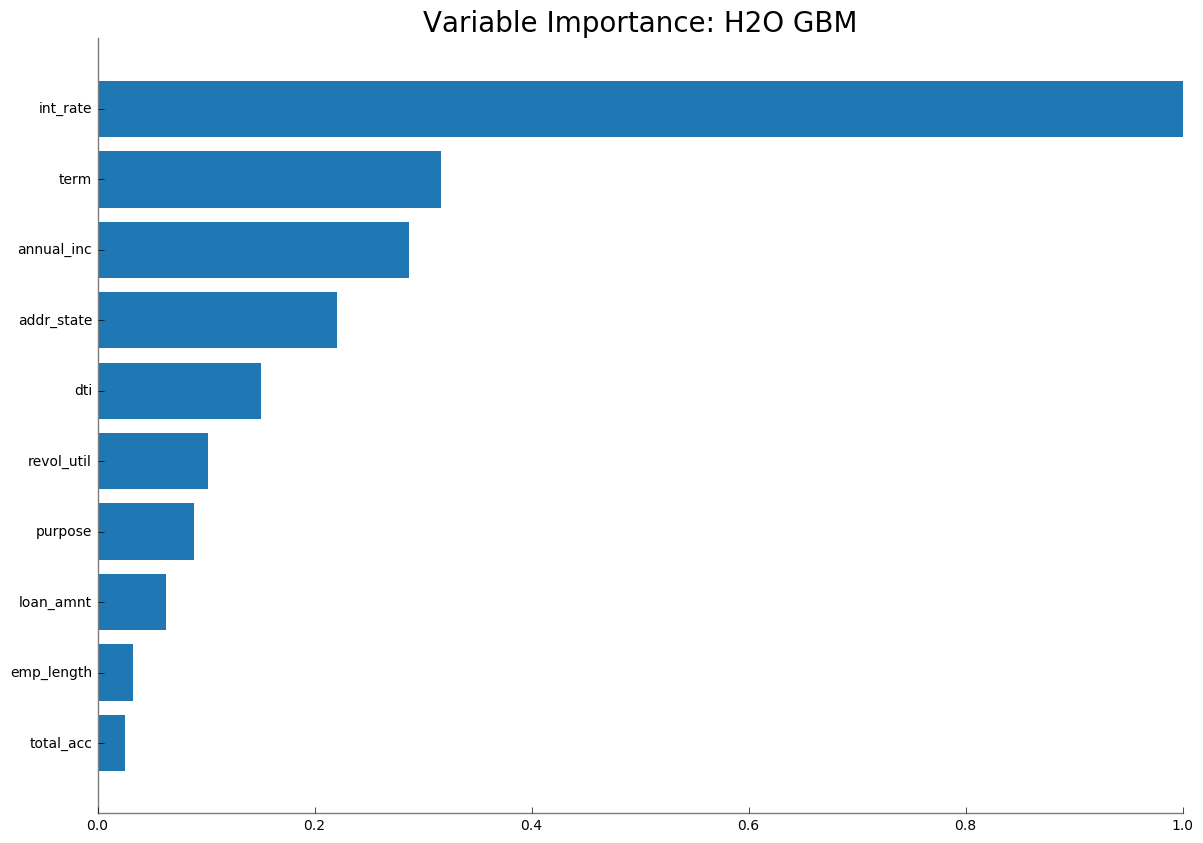

In [16]:
# analyze variable importance
gbm_model.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


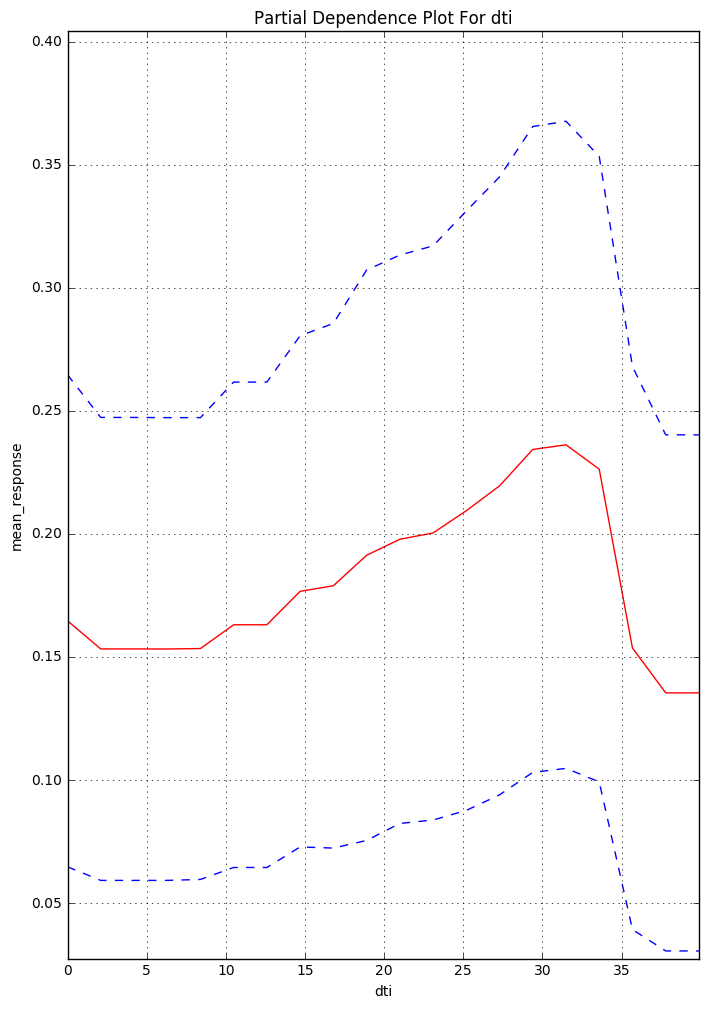

In [17]:
# partial dependence plots are a powerful machine learning interpretation tool
# to calculate partial dependence across the domain a variable
# hold column of interest at constant value
# find the mean prediction of the model with this column constant
# repeat for multiple values of the variable of interest
# h2o has a built-in function for partial dependence as well
par_dep_dti1 = gbm_model.partial_plot(data=train, cols=['dti'], server=True, plot=True)

In [18]:
# shutdown h2o ... be careful this can erase your work
# h2o.cluster().shutdown(prompt=True)